In [1]:

import h5py
import numpy as np


import os
import sys
import warnings
import random
from typing import Dict, List, Optional
from types import SimpleNamespace
from itertools import chain, combinations
import numpy as np
import pandas as pd
import re
import time
from tqdm import tqdm
import h5py

# Importing the ML and transformers libraries
import torch
from torch import cuda
from torch import nn
from torchmetrics import MeanSquaredError
from torch.utils.data import Dataset, DataLoader, BatchSampler, SequentialSampler

from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification, RobertaConfig, Trainer, TrainingArguments, AutoModel, AutoTokenizer, EarlyStoppingCallback
#require sentencepiece

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import wandb

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy


# Set random seeds and deterministic pytorch for reproducibility
global_seed = 22
random.seed(global_seed)
torch.manual_seed(global_seed) 
np.random.seed(global_seed) 
torch.backends.cudnn.deterministic = True


def load_hdf_embed_checkpoint(hdf_filepath, verbose=True):
    with h5py.File(hdf_filepath, "r") as file:
        article_ids = np.array(file["article_ids"], dtype=str)
        targets = np.array(file["targets"], dtype=np.float32)
        text_embeds = np.array(file["text_embeddings"], dtype=np.float32)
        
        #Rescale and recenter sll features around 0.0
        padd_mask = np.std(text_embeds, axis=0) < 1e-6
        text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)
        text_embeds[:, padd_mask] = 0.0
        if verbose:
            print(f"article_ids: {type(article_ids)}, {article_ids.shape}")
            print(f"targets: {type(targets)}, {targets.shape}")
            print(f"text_embeds: {type(text_embeds)}, {text_embeds.shape}")

        return article_ids, targets, text_embeds


def get_predict_data_filepath(predict_feature, input_type, embed_type):

    #base_folder = "S:/Sync/University/2023_MRP_1/MRP1_WorkDir/model_scripts/embed_checkpointsv" + predict_feature + "/" + input_type + "/"
    base_folder = "./embed_checkpoints/" + predict_feature + "/" + input_type + "/"
    
    predict_feature = "_senti" if predict_feature == "sentiment" else ""
    # You can uncomment the following line if needed, but please make sure to define the variable input_type
    # predict_feature = predict_feature + "_subtextLevel" if input_type == "subtextLevel" else predict_feature
    exchange_model = True if embed_type == "xlnet" else False
    embed_type = "zero" if embed_type == "xlnet" else embed_type



    if input_type == "headline":
        train_data_filepath = base_folder + "train" + predict_feature + "_distilroberta_" + embed_type + "_embeddings.hdf5"
    elif input_type == "body":
        train_data_filepath = base_folder + "train" + predict_feature + "_distilroberta_body_" + embed_type + "_embeddings.hdf5"
    elif input_type == "subtextLevel":
        train_data_filepath = base_folder + "train" + predict_feature + "_subtextLevel_distilroberta_" + embed_type + "_embeddings.hdf5"

    if exchange_model:
        train_data_filepath = train_data_filepath.replace("distilroberta", "xlnet")

    return train_data_filepath


model_output_dir = "./models/gp_checkpointed_embeds/"


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

c_train_filepath = "./embed_checkpoints/engagement/body/train_distilroberta_body_zero_embeddings.hdf5"
#c_train_filepath = "./embed_checkpoints/engagement/headline/train_distilroberta_zero_embeddings.hdf5"
#c_train_filepath = "./embed_checkpoints/engagement/train_roberta_zero_embeddings.hdf5"

#c_train_filepath = "./embed_checkpoints/sentiment/body/train_senti_distilroberta_body_zero_embeddings.hdf5"

feat = "sentiment"
feat = "engagement"

c_train_filepath = get_predict_data_filepath(feat, 
                                             "body",   #"subtextLevel", "headline", "body"
                                             "zero") #"SimCE-Head-Body", "CosSim", "zero", "xlnet"

c_train_filepath = get_predict_data_filepath(feat, 
                                             "subtextLevel",   #"subtextLevel", "headline", "body"
                                             "xlnet") #"SimCE-Head-Body", "CosSim", "zero", "xlnet"


c_test_filepath = re.sub("train", "test", c_train_filepath)


### import "S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\annotated\\r_art_stratified_annotated_with_first_scores.csv"
#first_art_df = pd.read_csv("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\annotated\\r_art_stratified_annotated_with_first_scores.csv")

article_ids, targets, text_embeds = load_hdf_embed_checkpoint(c_train_filepath)

article_id_train = article_ids
X_train = text_embeds
y_train = targets
#Extract the targets from the first_art_df based on the article_id_train
#y_train = np.array([])
#for article_id in article_id_train:
#    y_train = np.append(y_train, first_art_df.loc[first_art_df["article_id"] == article_id, f"first_{feat}_score"].values)
    
#Ensure that the targets are in the same order as the article_id_train

article_ids, targets, text_embeds = load_hdf_embed_checkpoint(c_test_filepath)

article_id_val = article_ids
X_val = text_embeds
y_val = targets
#Extract the targets from the first_art_df based on the article_id_val
#y_val = np.array([])
#for article_id in article_id_val:
#    y_val = np.append(y_val, first_art_df.loc[first_art_df["article_id"] == article_id, f"first_{feat}_score"].values)
#y_val = np.append(y_val, np.mean(y_val))

print(article_id_train.shape, X_train.shape, y_train.shape)
print(article_id_val.shape, X_val.shape, y_val.shape)
assert X_train.shape[0] == y_train.shape[0]


article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 1024)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 1024)
(98,) (98, 1024) (98, 1)
(25,) (25, 1024) (25, 1)


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel


def train_and_predict(X_t, y_t, X_v, y_v, verbose=True):
    regressor = SVR(verbose=True, kernel='rbf')
    #kernel = Matern() + WhiteKernel()
    #regressor = GaussianProcessRegressor(kernel=kernel, random_state=0)
    #regressor = SVR(verbose=True, kernel='rbf')
    #print(kernel.get_params().keys())
    svm_parameters = {
    #'estimator__kernel': ('poly', 'rbf', 'linear', 'sigmoid', 'precomputed'), #Linear already tested
    #'estimator__tol': (1e-2, 1e-3, 1e-4),
    #'estimator__epsilon': (0.1, 0.2, 0.3),
    #'kernel': ('poly', 'rbf'), #Linear already tested
    'tol': tuple(np.linspace(1e-3, 0.1, 10)), #tol = tolerance for stopping criterion
    'epsilon': tuple(np.linspace(1e-4, 0.1, 100)), # epsilon = epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.
    #'nu': tuple(np.linspace(0.001, 0.01, 10)),
    'C': (10, 5, 1, 0.1, 0.01, 0.001), #C = Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.
    }

    gp_parameters = {
            'kernel__k1__length_scale' : (1e-2, 1e-1, 1, 10, 100),
            'kernel__k1__nu' : (1.5, 2.5),
            'kernel__k2__noise_level' : (1e-2, 1e-1, 1, 10, 100),
    }

    gs_regressor = GridSearchCV(regressor, svm_parameters, cv=5, n_jobs=-1, verbose=10)
    gs_regressor.fit(X_t, np.ravel(y_t))

    predictions = gs_regressor.predict(X_v)

    if verbose:
        print("===== Grid search results =====")
        #print(gs_regressor.cv_results_)
        print(gs_regressor.best_score_)
        print(gs_regressor.best_params_)

        print("=====================================")
        
    regressor = SVR(kernel='rbf',**gs_regressor.best_params_, verbose=True)
    #Cut away the best_params_ key substring "kernel__k1__"
    #k1_params = {re.sub(r'kernel__k1__', '', k): v for k, v in gs_regressor.best_params_.items() if "k1" in k}
    #k2_params = {re.sub(r'kernel__k2__', '', k): v for k, v in gs_regressor.best_params_.items() if "k2" in k}
    # kernel = Matern(**k1_params) + WhiteKernel(**k2_params)
    #regressor = GaussianProcessRegressor(kernel=kernel, random_state=0)
    regressor.fit(X_t, np.ravel(y_t))

    predictions = regressor.predict(X_v)
    train_predictions = regressor.predict(X_t)
    if verbose:
        print(list(zip(predictions, np.ravel(y_v))))

    y_t, y_v = np.ravel(y_t), np.ravel(y_v)

    #Print train and validation MSE and RMSE
    perform_meas = {}
    perform_meas["mse_train"] = mean_squared_error(y_t, train_predictions)
    perform_meas["mse_val"] = mean_squared_error(y_v, predictions)
    perform_meas["rmse_train"] = np.sqrt(mean_squared_error(y_t, train_predictions))
    perform_meas["rmse_val"] = np.sqrt(mean_squared_error(y_v, predictions))
    perform_meas["adjusted_r2_train"] = r2_score(y_t, train_predictions)
    perform_meas["adjusted_r2_val"] =  r2_score(y_v, predictions)
    perform_meas["pcc_train"] = pearsonr(y_t, train_predictions)[0]
    perform_meas["pcc_val"] = pearsonr(y_v, predictions)[0]
    perform_meas["cv_results"] = gs_regressor.cv_results_
    perform_meas["cv_best_params"] = gs_regressor.best_params_
    perform_meas["cv_best_score"] = gs_regressor.best_score_
    
    if verbose:
        print(perform_meas)

    return train_predictions, predictions, perform_meas


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel


def cv_reg_train_and_predict(X_t, y_t, X_v, y_v, verbose=True):
    regressor = SVR(verbose=True, kernel='rbf')
    #kernel = Matern() + WhiteKernel()
    #regressor = GaussianProcessRegressor(kernel=kernel, random_state=0)
    #regressor = SVR(verbose=True, kernel='rbf')
    #print(kernel.get_params().keys())
    svm_parameters = {
    #'estimator__kernel': ('poly', 'rbf', 'linear', 'sigmoid', 'precomputed'), #Linear already tested
    #'estimator__tol': (1e-2, 1e-3, 1e-4),
    #'estimator__epsilon': (0.1, 0.2, 0.3),
    #'kernel': ('poly', 'rbf'), #Linear already tested
    'tol': tuple(np.linspace(1e-3, 0.1, 10)),
    'epsilon': tuple(np.linspace(1e-3, 0.2, 100)),
    #'nu': tuple(np.linspace(0.001, 0.01, 10)),
    'C': (100, 10, 5, 1, 0.1, 0.01, 0.001),
    }

    gp_parameters = {
            'kernel__k1__length_scale' : (1e-2, 1e-1, 1, 10, 100),
            'kernel__k1__nu' : (1.5, 2.5),
            'kernel__k2__noise_level' : (1e-2, 1e-1, 1, 10, 100),
    }

    gs_regressor = GridSearchCV(regressor, svm_parameters, cv=5, n_jobs=-1, verbose=10, scoring='r2')

    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)

    gs_regressor.fit(X, np.ravel(y))

    predictions = cross_val_predict(regressor, X, y, cv=5)

    #predictions = gs_regressor.predict(X_v)
    
    
    if verbose:
        print("===== Grid search results =====")
        #print(gs_regressor.cv_results_)
        print(gs_regressor.best_score_)
        print(gs_regressor.best_params_)

        print("=====================================")
        
    regressor = SVR(kernel='rbf',**gs_regressor.best_params_, verbose=True)
    #Cut away the best_params_ key substring "kernel__k1__"
    #k1_params = {re.sub(r'kernel__k1__', '', k): v for k, v in gs_regressor.best_params_.items() if "k1" in k}
    #k2_params = {re.sub(r'kernel__k2__', '', k): v for k, v in gs_regressor.best_params_.items() if "k2" in k}
    # kernel = Matern(**k1_params) + WhiteKernel(**k2_params)
    #regressor = GaussianProcessRegressor(kernel=kernel, random_state=0)
    #regressor.fit(X, np.ravel(y))
    scores = cross_val_score(regressor, X, y, cv=5)
    
    #predictions = regressor.predict(X_v)
    #train_predictions = regressor.predict(X_t)
    train_predictions, val_predictions = predictions[:len(X_t)], predictions[len(X_t):]
    predictions = val_predictions

    if verbose:
        print(list(zip(predictions, np.ravel(y_v))))

    y_t, y_v = np.ravel(y_t), np.ravel(y_v)

    #Print train and validation MSE and RMSE
    perform_meas = {}
    n, p = X.shape
    perform_meas["mse_train"] = mean_squared_error(y_t, train_predictions)
    perform_meas["mse_val"] = mean_squared_error(y_v, predictions)
    perform_meas["rmse_train"] = np.sqrt(mean_squared_error(y_t, train_predictions))
    perform_meas["rmse_val"] = np.sqrt(mean_squared_error(y_v, predictions))
    perform_meas["adjusted_r2_train"] = r2_score(y_t, train_predictions)
    perform_meas["adjusted_r2_val"] =  r2_score(y_v, predictions)
    perform_meas["pcc_train"] = pearsonr(y_t, train_predictions)[0]
    perform_meas["pcc_val"] = pearsonr(y_v, predictions)[0]
    perform_meas["cv_results"] = gs_regressor.cv_results_
    perform_meas["cv_best_params"] = gs_regressor.best_params_
    perform_meas["cv_best_score"] = gs_regressor.best_score_
    
    if verbose:
        print(perform_meas)

    return train_predictions, predictions, perform_meas

Fitting 5 folds for each of 7000 candidates, totalling 35000 fits
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]===== Grid search results =====
0.05667892489856319
{'C': 100, 'epsilon': 0.08140404040404041, 'tol': 0.08900000000000001}
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][(0.3149510745455361, 0.375), (0.37506127226312486, 0.30625), (0.38350290489401223, 0.53125), (0.32577146473822005, 0.2625), (0.3545264402564605, 0.4875), (0.3746810654952215, 0.4125), (0.3720821568720366, 0.50625), (0.3358798289858443, 0.325), (0.360699834842358, 0.50625), (0.33930210207777545, 0.15625), (0.34299541282626933, 0.25), (0.3225627952573, 0.225), (0.36447113029683087, 0.3875), (0.3755142751402403, 0.375), (0.31310217400610735, 0.25), (0.35058313553907705, 0.30625), (0.3617595999374628, 0.38125), (0.38276884730711075, 0.375), (0.3096317326027768, 0.4125), (0.35813708565715946, 0.3875), (0.37864389362818707, 0.525), (0.32002153285821655, 0.23125), (0.32699734734807673, 0.3625), (0.3647106019877774, 0.34

C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

Text(0, 0.5, 'Actual')

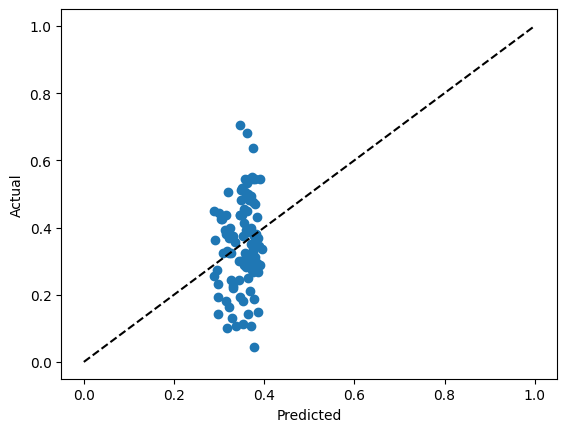

In [23]:
#train_predictions, predictions, perform_measures = train_and_predict(X_train, y_train,X_val, y_val)

train_predictions, predictions, perform_measures = cv_reg_train_and_predict(X_train, y_train,X_val, y_val)


import matplotlib.pyplot as plt
plt.scatter(train_predictions, y_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted')
plt.ylabel('Actual')

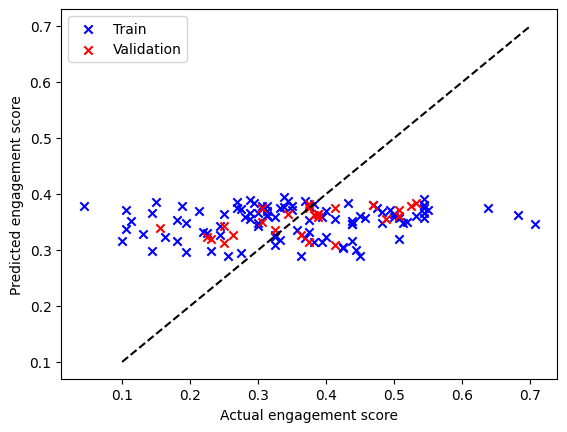

In [24]:
import matplotlib.pyplot as plt
plt.plot([0.1, 0.7], [0.1, 0.7], 'k--')
plt.scatter(y_train,train_predictions,  marker="x", color="blue", label="Train")
plt.scatter(y_val, predictions,marker="x", color="red", label="Validation")
plt.ylabel('Predicted {} score'.format(feat))
plt.xlabel('Actual {} score'.format(feat))
plt.legend()

#plt.savefig('{}_svm_predictions.png'.format(feat), dpi=300)

In [11]:
perform_measures

{'mse_train': 0.0067979936143493114,
 'mse_val': 0.007026385981380313,
 'rmse_train': 0.08244994611489635,
 'rmse_val': 0.08382354073516766,
 'adjusted_r2_train': 0.03084651196425725,
 'adjusted_r2_val': -0.676666555424551,
 'pcc_train': 0.31555655940903315,
 'pcc_val': 0.23651254322772616,
 'cv_results': {'mean_fit_time': array([0.01153655, 0.00428047, 0.00463562, ..., 0.00020084, 0.        ,
         0.00363283]),
  'std_fit_time': array([0.00622308, 0.00362612, 0.00336284, ..., 0.00040169, 0.        ,
         0.00444929]),
  'mean_score_time': array([0.0023973 , 0.00350008, 0.00370507, ..., 0.        , 0.        ,
         0.00363283]),
  'std_score_time': array([0.00198311, 0.0018833 , 0.00256113, ..., 0.        , 0.        ,
         0.00444929]),
  'param_C': masked_array(data=[100, 100, 100, ..., 0.001, 0.001, 0.001],
               mask=[False, False, False, ..., False, False, False],
         fill_value='?',
              dtype=object),
  'param_epsilon': masked_array(data=[0

In [ ]:
from sklearn.metrics import explained_variance_score

explained_variance_score(y_val, predictions)

0.019366374510242035

Text(0, 0.5, 'Actual')

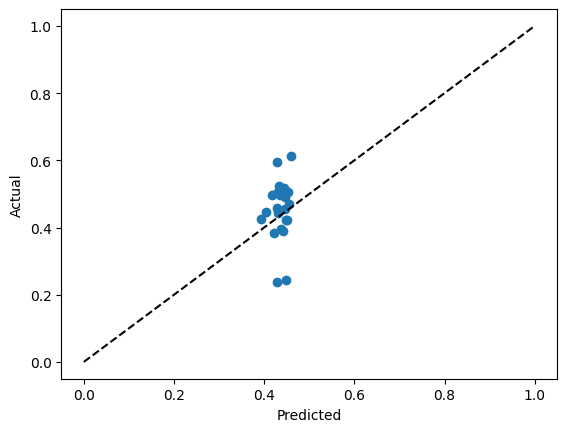

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(predictions, y_val)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted')
plt.ylabel('Actual')

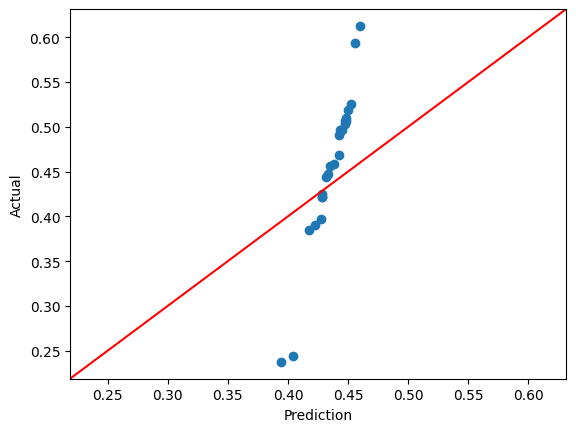

In [ ]:
import statsmodels.api as sm
import pylab as py
  
# np.random generates different random numbers
# whenever the code is executed
# Note: When you execute the same code 
# the graph look different than shown below.
  
# Random data points generated
sm.qqplot_2samples(predictions, 
                   y_val,
                     xlabel = "Prediction",
                    ylabel = "Actual",  
                    line ='45', #“r” , “s” , "45"
                    )

# Set xlim and ylim
#py.xlim(0, 1)
#py.ylim(0, 1)
#sm.qqplot(data_points, line ='45')
py.show()

In [ ]:
pred_feature_list = ['sentiment', 'engagement']
input_type_list = ['headline', 'body', 'subtextLevel']
embed_type_list = ['zero', "SimCE-Head-Body", "CosSim", "xlnet"]

train_output_summaries, val_output_summaries = {}, {}
for c_pred_feature in pred_feature_list:
    train_output_summaries[c_pred_feature] = pd.DataFrame(columns=[input_type_list], index=embed_type_list)
    val_output_summaries[c_pred_feature] = pd.DataFrame(columns=[input_type_list], index=embed_type_list)
    for c_embed_type in tqdm(embed_type_list, desc=" Looping embed_type for {}".format(c_pred_feature), position=0):
        train_res_str_df_row = []
        val_res_str_df_row = []
        
        for c_input_type in tqdm(input_type_list, desc=" Looping input_type", position=1, leave=False):
            c_train_filepath = get_predict_data_filepath(c_pred_feature,
                                                c_input_type,
                                                c_embed_type,
                                                )

            c_test_filepath = re.sub("train", "test", c_train_filepath)

            article_ids, targets, text_embeds = load_hdf_embed_checkpoint(c_train_filepath, verbose=False)

            article_id_train = article_ids
            X_train = text_embeds
            y_train = targets

            article_ids, targets, text_embeds = load_hdf_embed_checkpoint(c_test_filepath, verbose=False)

            article_id_val = article_ids
            X_val = text_embeds
            y_val = targets

            # End of loading data
            train_predictions, predictions, perform_measures = cv_reg_train_and_predict(X_train, y_train,X_val, y_val, verbose=False)

            # Save results in string with the RMSE as main metrics and the PCC in parenthesis
            #Rpeat but round up to 2 decimals
            train_res_str = "{}".format(round(perform_measures["rmse_train"], 3), round(perform_measures["adjusted_r2_train"], 3))
            train_res_str = "{} ({})".format(round(perform_measures["rmse_train"], 3), round(perform_measures["adjusted_r2_train"], 3))
            
            train_res_str_df_row.append(train_res_str)
            val_res_str = "{} ({})".format(round(perform_measures["rmse_val"], 3), round(perform_measures["adjusted_r2_val"], 3))
            
            val_res_str_df_row.append(val_res_str)
    
        train_output_summaries[c_pred_feature].loc[c_embed_type] = train_res_str_df_row
        val_output_summaries[c_pred_feature].loc[c_embed_type] = val_res_str_df_row
    

train_output_summaries["engagement"].to_csv("train_output_summaries_engagement.csv")
train_output_summaries["sentiment"].to_csv("train_output_summaries_sentiment.csv")
val_output_summaries["engagement"].to_csv("val_output_summaries_engagement.csv")
val_output_summaries["sentiment"].to_csv("val_output_summaries_sentiment.csv")



 Looping embed_type for sentiment:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\trothe\AppData\Local\Temp\ipykernel_2948\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)


Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Temp\ipykernel_2948\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundatio

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Temp\ipykernel_2948\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundatio

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

 Looping embed_type for engagement:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Temp\ipykernel_2948\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundatio

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Temp\ipykernel_2948\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundatio

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Temp\ipykernel_2948\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundatio

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [ ]:
from tabulate import tabulate
engagement_table = tabulate(val_output_summaries["engagement"], headers='keys', tablefmt="fancy_grid")

# Print the table
print(engagement_table)


╒═════════════════╤═════════════════╤════════════════╤═════════════════════╕
│                 │ ('headline',)   │ ('body',)      │ ('subtextLevel',)   │
╞═════════════════╪═════════════════╪════════════════╪═════════════════════╡
│ zero            │ 0.108 (-0.165)  │ 0.097 (0.073)  │ 0.107 (-0.138)      │
├─────────────────┼─────────────────┼────────────────┼─────────────────────┤
│ SimCE-Head-Body │ 0.104 (-0.066)  │ 0.097 (0.071)  │ 0.102 (-0.024)      │
├─────────────────┼─────────────────┼────────────────┼─────────────────────┤
│ CosSim          │ 0.106 (-0.122)  │ 0.106 (-0.113) │ 0.101 (-0.021)      │
├─────────────────┼─────────────────┼────────────────┼─────────────────────┤
│ xlnet           │ 0.101 (-0.013)  │ 0.094 (0.131)  │ 0.09 (0.2)          │
╘═════════════════╧═════════════════╧════════════════╧═════════════════════╛


In [ ]:
# In latex that is:
engagement_table = tabulate(val_output_summaries["sentiment"], headers='keys', tablefmt="latex")
engagement_table

"\\begin{tabular}{llll}\n\\hline\n                 & ('headline',)   & ('body',)      & ('subtextLevel',)   \\\\\n\\hline\n zero            & 0.089 (-0.878)  & 0.084 (-0.677) & 0.092 (-1.033)      \\\\\n SimCE-Head-Body & 0.088 (-0.862)  & 0.087 (-0.795) & 0.091 (-0.977)      \\\\\n CosSim          & 0.086 (-0.783)  & 0.093 (-1.064) & 0.092 (-1.021)      \\\\\n xlnet           & 0.089 (-0.879)  & 0.085 (-0.706) & 0.089 (-0.886)      \\\\\n\\hline\n\\end{tabular}"

### SVC

In [6]:

c_train_filepath = "./embed_checkpoints/engagement/body/train_distilroberta_body_zero_embeddings.hdf5"
c_train_filepath = "./embed_checkpoints/engagement/headline/train_distilroberta_zero_embeddings.hdf5"
c_train_filepath = "./embed_checkpoints/engagement/train_roberta_zero_embeddings.hdf5"

#c_train_filepath = "./embed_checkpoints/sentiment/body/train_senti_distilroberta_body_zero_embeddings.hdf5"

c_train_filepath = get_predict_data_filepath("engagement", 
                                             "body",   #"subtextLevel", "headline", "body"
                                             "zero") #"SimCE-Head-Body", "CosSim", "zero", "xlnet"


c_test_filepath = re.sub("train", "test", c_train_filepath)

train_article_ids, train_targets, train_text_embeds = load_hdf_embed_checkpoint(c_train_filepath)
val_article_ids, val_targets, val_text_embeds = load_hdf_embed_checkpoint(c_test_filepath)


#Merge train and val data into one dataset
article_ids = np.concatenate((train_article_ids, val_article_ids))
targets = np.concatenate((train_targets, val_targets))
text_embeds = np.concatenate((train_text_embeds, val_text_embeds))
np.random.seed(42)
np.random.shuffle(article_ids)
np.random.shuffle(targets)
np.random.shuffle(text_embeds)

mean_tolerence_threshold = np.std(targets) / 4
print("Data mean", np.mean(targets))
print("Mean tolerence threshold: ", mean_tolerence_threshold)

X = text_embeds
#Transform labels into 3 integer classses: about average, above average, below average
targets = np.array([2 if t > np.mean(targets)+mean_tolerence_threshold else 0 if t < np.mean(targets) - mean_tolerence_threshold else 1 for t in targets])
y = targets

X_test = val_text_embeds
y_test = np.array([2 if t > np.mean(val_targets)+mean_tolerence_threshold else 0 if t < np.mean(val_targets) - mean_tolerence_threshold else 1 for t in val_targets])

print(np.histogram(y, bins=3))


article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
(array([48, 27, 48], dtype=int64), array([0.        , 0.66666667, 1.33333333, 2.        ]))


C:\Users\trothe\AppData\Local\Temp\ipykernel_25784\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)


(array([48,  0,  0,  0,  0, 27,  0,  0,  0, 48], dtype=int64), array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]))


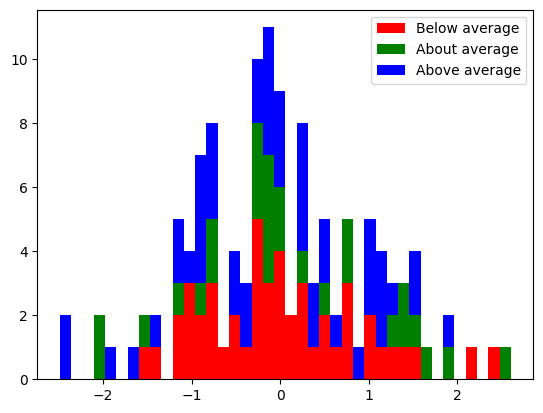

In [7]:
import matplotlib as mpl
#Histogram of labels:
#plt = pd.Series(np.ravel(y_train)).hist(bins=10)
#plt.set_title("Histogram of labels")
#plt.set_xlabel("Label")
#plt.set_ylabel("Frequency")

hist =  np.histogram(np.ravel(y), bins=10)
print(hist)

# Groupeed stack histogram along X hidden dimension 2
cls1_inds = y == 0
cls2_inds = y == 1
cls3_inds = y == 2
X_1 = X[cls1_inds, :]
X_2 = X[cls2_inds, :]
X_3 = X[cls3_inds, :]

hidden_dim_idx = 10
plt = mpl.pyplot.hist([X_1[:, hidden_dim_idx], X_2[:, hidden_dim_idx], X_3[:, hidden_dim_idx]], bins=40, stacked=True, color=['red', 'green', 'blue'], label=['Below average', 'About average', 'Above average'])
mpl.pyplot.legend(loc='upper right')

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score


def clf_train_and_predict(X, y, verbose=True):
    clf = OneVsOneClassifier(SVC(verbose=True))
    #regressor = SVR(verbose=True, kernel='rbf')

    parameters = {
    #'estimator__kernel': ('poly', 'rbf', 'linear', 'sigmoid', 'precomputed'), #Linear already tested
    'estimator__tol': (1e-1,1e-2,1e-3, 1e-4, 1e-5, 1e-6),
    #'estimator__epsilon': tuple(np.exp(np.logspace(-4, -1, 10))),
    'estimator__kernel': ('poly','rbf', 'linear'), #Linear already tested
    'estimator__degree': (1, 2,3,4,5),
    'estimator__C': (0.01,0.05, 0.1,0.5, 1,2,4,5,8, 10,20),
    }

    gs_clf = GridSearchCV(clf, parameters, cv=5, n_jobs=-1, verbose=10)
    gs_clf.fit(X, np.ravel(y))

    predictions = cross_val_predict(gs_clf, X, y, cv=5)

    if verbose:
        print("===== Grid search results =====")
        #print(gs_regressor.cv_results_)
        print(gs_clf.best_score_)
        print(gs_clf.best_params_)

        print("=====================================")

    #Remove the "estimator__" prefix from prarms_ keys:
    gs_clf.best_params_ = {key.replace("estimator__", ""): value for key, value in gs_clf.best_params_.items()}

    clf =  OneVsOneClassifier(SVC(**gs_clf.best_params_, verbose=True))
    #clf.fit(X, np.ravel(y))
    
    scores = cross_val_score(clf, X, y, cv=5)
    y = np.ravel(y)

    #Print train and validation MSE and RMSE
    perform_meas = {}
    perform_meas["cv_accuracy"] = accuracy_score(y, predictions)
    perform_meas["cv_f1_score"] = f1_score(y, predictions, average='weighted')
    #perform_meas["cv_recall"] = recall_score(y, predictions)
    #perform_meas["cv_results"] = gs_clf.cv_results_
    perform_meas["cv_best_params"] = gs_clf.best_params_
    perform_meas["cv_best_score"] = gs_clf.best_score_
    perform_meas["cv_confusion_matrix"] = sklearn.metrics.confusion_matrix(y, predictions)
    
    if verbose:
        print(list(zip(predictions, np.ravel(y))))
        print(perform_meas)

    
    return predictions, perform_meas

In [36]:
predictions, perform_measures = clf_train_and_predict(X, y)

confusion_matrix = perform_measures['cv_confusion_matrix']

Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]===== Grid search results =====
0.4716666666666667
{'estimator__C': 5, 'estimator__degree': 5, 'estimator__kernel': 'poly', 'estimator__tol': 0.1}
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][(2, 2), (2, 1), (2, 2), (2, 0), (2, 0), (0, 1), (2, 1), (2, 2), (2, 2), (2, 2), (2, 1), (2, 1), (2, 2), (2, 0), (2, 1), (2, 1), (2, 0), (2, 2), (2, 2), (2, 2), (2, 0), (2, 1), (2, 0), (2, 0), (2, 2), (2, 

In [37]:
perform_measures

{'cv_accuracy': 0.42276422764227645,
 'cv_f1_score': 0.28690153568202353,
 'cv_best_params': {'C': 5, 'degree': 5, 'kernel': 'poly', 'tol': 0.1},
 'cv_best_score': 0.4716666666666667,
 'cv_confusion_matrix': array([[ 1,  0, 37],
        [ 3,  0, 26],
        [ 3,  2, 51]], dtype=int64)}

In [38]:
confusion_matrix

array([[ 1,  0, 37],
       [ 3,  0, 26],
       [ 3,  2, 51]], dtype=int64)

In [39]:
pred_feature_list = ['sentiment', 'engagement']
input_type_list = ['headline', 'body', 'subtextLevel']
embed_type_list = ['zero', "SimCE-Head-Body", "CosSim", "xlnet"]

train_output_summaries, val_output_summaries = {}, {}
for c_pred_feature in pred_feature_list:
    train_output_summaries[c_pred_feature] = pd.DataFrame(columns=[input_type_list], index=embed_type_list)
    #val_output_summaries[c_pred_feature] = pd.DataFrame(columns=[input_type_list], index=embed_type_list)
    for c_embed_type in tqdm(embed_type_list, desc=" Looping embed_type for {}".format(c_pred_feature), position=0):
        train_res_str_df_row = []
        #val_res_str_df_row = []
        
        for c_input_type in tqdm(input_type_list, desc=" Looping input_type", position=1, leave=False):
            c_train_filepath = get_predict_data_filepath(c_pred_feature,
                                                c_input_type,
                                                c_embed_type,
                                                )

            c_test_filepath = re.sub("train", "test", c_train_filepath)


            train_article_ids, train_targets, train_text_embeds = load_hdf_embed_checkpoint(c_train_filepath)
            val_article_ids, val_targets, val_text_embeds = load_hdf_embed_checkpoint(c_test_filepath)


            #Merge train and val data into one dataset
            article_ids = np.concatenate((train_article_ids, val_article_ids))
            targets = np.concatenate((train_targets, val_targets))
            text_embeds = np.concatenate((train_text_embeds, val_text_embeds))
            np.random.seed(42)
            np.random.shuffle(article_ids)
            np.random.shuffle(targets)
            np.random.shuffle(text_embeds)

            mean_tolerence_threshold = np.std(targets) / 4
            print("Data mean", np.mean(targets))
            print("Mean tolerence threshold: ", mean_tolerence_threshold)

            X = text_embeds
            #Transform labels into 3 integer classses: about average, above average, below average
            targets = np.array([2 if t > np.mean(targets)+mean_tolerence_threshold else 0 if t < np.mean(targets) - mean_tolerence_threshold else 1 for t in targets])
            y = targets

            # End of loading data
            predictions, perform_measures = clf_train_and_predict(X, y, verbose=False)

            # Save results in string with the RMSE as main metrics and the PCC in parenthesis
            #Rpeat but round up to 2 decimals
            #train_res_str = "{}".format(round(perform_measures["rmse_train"], 3), round(perform_measures["pcc_train"], 3))
            train_res_str = "{} ({})".format(round(perform_measures["cv_accuracy"], 3), round(perform_measures["cv_f1_score"], 3))
            
            train_res_str_df_row.append(train_res_str)
            #val_res_str = "{} ({})".format(round(perform_measures["rmse_val"], 3), round(perform_measures["pcc_val"], 3))
            
            #val_res_str_df_row.append(val_res_str)
    
        train_output_summaries[c_pred_feature].loc[c_embed_type] = train_res_str_df_row
        #val_output_summaries[c_pred_feature].loc[c_embed_type] = val_res_str_df_row
    

train_output_summaries["engagement"].to_csv("cv_class_output_summaries_engagement.csv")
train_output_summaries["sentiment"].to_csv("cv_class_output_summaries_sentiment.csv")


 Looping embed_type for sentiment:   0%|          | 0/4 [00:00<?, ?it/s]C:\Users\trothe\AppData\Local\Temp\ipykernel_2428\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)


article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.46262705
Mean tolerence threshold:  0.02028130367398262
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.46262705
Mean tolerence threshold:  0.02028130367398262
Fitting 5 folds for each of 990 candidates, totalling 4950 fits


C:\Users\trothe\AppData\Local\Temp\ipykernel_2428\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)


[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.46262705
Mean tolerence threshold:  0.02028130367398262
Fitting 5 folds for each of 990 candidates, totalling 4950 fits


C:\Users\trothe\AppData\Local\Temp\ipykernel_2428\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)


[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


 Looping embed_type for sentiment:  25%|██▌       | 1/4 [02:06<06:19, 126.46s/it]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.46262705
Mean tolerence threshold:  0.02028130367398262
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.46262705
Mean tolerence threshold:  0.02028130367398262
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.46262705
Mean tolerence threshold:  0.02028130367398262
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


 Looping embed_type for sentiment:  50%|█████     | 2/4 [04:29<04:32, 136.28s/it]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.46262705
Mean tolerence threshold:  0.02028130367398262
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.46262705
Mean tolerence threshold:  0.02028130367398262
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.46262705
Mean tolerence threshold:  0.02028130367398262
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


 Looping embed_type for sentiment:  75%|███████▌  | 3/4 [07:10<02:27, 147.31s/it]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 1024)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 1024)
Data mean 0.46262705
Mean tolerence threshold:  0.02028130367398262
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 1024)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 1024)
Data mean 0.46262705
Mean tolerence threshold:  0.02028130367398262
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 1024)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 1024)
Data mean 0.46262705
Mean tolerence threshold:  0.02028130367398262
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


 Looping embed_type for sentiment: 100%|██████████| 4/4 [10:27<00:00, 156.84s/it]


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

 Looping embed_type for engagement:   0%|          | 0/4 [00:00<?, ?it/s]

article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
Fitting 5 folds for each of 990 candidates, totalling 4950 fits


C:\Users\trothe\AppData\Local\Temp\ipykernel_2428\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)


[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
Fitting 5 folds for each of 990 candidates, totalling 4950 fits


C:\Users\trothe\AppData\Local\Temp\ipykernel_2428\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)


[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
Fitting 5 folds for each of 990 candidates, totalling 4950 fits


C:\Users\trothe\AppData\Local\Temp\ipykernel_2428\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)


[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


 Looping embed_type for engagement:  25%|██▌       | 1/4 [03:22<10:08, 202.95s/it]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


 Looping embed_type for engagement:  50%|█████     | 2/4 [05:54<05:45, 172.65s/it]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


 Looping embed_type for engagement:  75%|███████▌  | 3/4 [07:23<02:14, 134.72s/it]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 1024)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 1024)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 1024)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 1024)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 1024)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 1024)
Data mean 0.35497966
Mean tolerence threshold:  0.032020457088947296
Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits
[LibSVM][LibSVM][LibSVM]Fitting 5 folds for each of 990 candidates, totalling 4950 fits


 Looping embed_type for engagement: 100%|██████████| 4/4 [09:08<00:00, 137.13s/it]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [43]:
train_output_summaries["sentiment"]

,headline,body,subtextLevel
zero,0.415 (0.334),0.423 (0.287),0.423 (0.353)
SimCE-Head-Body,0.472 (0.345),0.447 (0.283),0.415 (0.309)
CosSim,0.455 (0.323),0.423 (0.317),0.39 (0.292)
xlnet,0.455 (0.324),0.439 (0.345),0.447 (0.344)
